In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import teotil3 as teo
from sqlalchemy import text

plt.style.use("ggplot")

In [3]:
# Connect to JupyterHub's PostGIS database
eng = nivapy.da.connect_postgis()

Connection successful.


# Retention in Øyeren

A back-of-the-envelope nitrogen budget for Øyeren based on recent monitoring data. This can be improved, but the aim here is just to quantify the main inflows and outflows.

## 1. Chemistry data from Vannmiljø

Looking at Vannmiljø, the main inflow to Øyeren has reasonable monitoring data at station `002-64432` (`Glomma ved Fetsund - G3`). There is also monitoring close to the main outflow at `002-28368` (`Glomma ved Solbergfoss`). Several smaller rivers discharge directly into Øyeren. Of these, Nitelva is the largest, but the data available are limited - just 24 samples between 2016 and 2021, collected at `002-81595` (`Nitelva (D9)`). Another significant inflow is Børterelva near Enebakk, which has reasonable data from `002-58956` (`Børterelva oppstrøms utløp ved Elverk - BRT1 / BØR1`).

In [4]:
# User input
vm_st_yr = 2013
vm_end_yr = 2023
vm_par_id = "N-TOT"

# Map VM station codes to regines for comparison with TEOTIL3 output
vm_stn_dict = {
    "002-64432": "002.D1",  # Glomma ved Fetsund - G3
    "002-81595": "002.CA4",  # Nitelva - D9 (inc. Leira)
    "002-58956": "002.C4B",  # Børterelva oppstrøms utløp ved Elverk - BRT1 / BØR1
    "002-28368": "002.B7",  # Glomma ved Solbergfoss
}

# Identify inflows and outflows
type_dict = {
    "002-64432": "main inflow",  # Glomma ved Fetsund - G3
    "002-81595": "minor inflow",  # Nitelva - D9 (inc. Leira)
    "002-58956": "minor inflow",  # Børterelva oppstrøms utløp ved Elverk - BRT1 / BØR1
    "002-28368": "main outflow",  # Glomma ved Solbergfoss
}

In [5]:
# Query results from VM API
vm_stn_ids = list(vm_stn_dict.keys())
data = {
    "FromDateSamplingTime": f"{vm_st_yr}-01-01",
    "ToDateSamplingTime": f"{vm_end_yr}-12-31",
    "FromRegDate": "1900-01-01",
    "WaterLocationCodeFilter": vm_stn_ids,
}
obs_df = nivapy.da.post_data_to_vannmiljo("GetRegistrations", data=data)
obs_df = obs_df.query(f"ParameterID in ['{vm_par_id}']")
obs_df["SamplingTime"] = pd.to_datetime(obs_df["SamplingTime"])
obs_df["Year"] = obs_df["SamplingTime"].dt.year
obs_df.rename(
    columns={
        "WaterLocationCode": "station_id",
        "Name": "name",
        "SamplingTime": "date",
        "ParameterID": "par",
        "ValueOperator": "flag",
        "RegValue": "value",
        "Unit": "unit",
    },
    inplace=True,
)
obs_df = obs_df.drop_duplicates(subset=["station_id", "date", "par"])

# Separate station info
stn_df = (
    obs_df[["station_id", "name", "CoordX", "CoordY"]]
    .drop_duplicates()
    .reset_index(drop=True)
)
stn_df["utm_zone"] = 33
stn_df = nivapy.spatial.utm_to_wgs84_dd(
    stn_df, zone="utm_zone", east="CoordX", north="CoordY"
)
stn_df = stn_df.drop(["CoordX", "CoordY", "utm_zone"], axis="columns")
stn_df["nve_dis_stn_id"] = "2.605.0"
stn_df["regine"] = stn_df["station_id"].map(vm_stn_dict)
stn_df["type"] = stn_df["station_id"].map(type_dict)

# Tidy
wc_cols = [
    "station_id",
    "name",
    "date",
    "par",
    "flag",
    "value",
    "unit",
]
obs_df = obs_df[wc_cols]

print("Station details:")
display(stn_df)

print("\nWater chemistry:")
obs_df.head()

Station details:


,station_id,name,lat,lon,nve_dis_stn_id,regine,type
0,002-64432,Glomma ved Fetsund - G3,59.923677,11.162343,2.605.0,002.D1,main inflow
1,002-28368,Glomma ved Solbergfoss,59.637843,11.154619,2.605.0,002.B7,main outflow
2,002-58956,Børterelva oppstrøms utløp ved Elverk - BRT1 /...,59.757292,11.168781,2.605.0,002.C4B,minor inflow
3,002-81595,Nitelva,59.937102,11.071566,2.605.0,002.CA4,minor inflow



Water chemistry:


,station_id,name,date,par,flag,value,unit
0,002-64432,Glomma ved Fetsund - G3,2014-06-30,N-TOT,=,380.0,µg/l N
6,002-64432,Glomma ved Fetsund - G3,2015-09-23,N-TOT,=,490.0,µg/l N
14,002-28368,Glomma ved Solbergfoss,2013-09-05,N-TOT,=,395.0,µg/l N
34,002-64432,Glomma ved Fetsund - G3,2014-09-14,N-TOT,=,345.0,µg/l N
45,002-58956,Børterelva oppstrøms utløp ved Elverk - BRT1 /...,2013-05-10,N-TOT,=,1500.0,µg/l N


In [6]:
# Plot stations
nivapy.spatial.quickmap(
    stn_df,
    lat_col="lat",
    lon_col="lon",
    cluster=False,
    popup="station_id",
)

In [7]:
# Check for major outliers at each site
df_list = []
stn_list = obs_df["station_id"].unique().tolist()
for stn_id in stn_list:
    df = obs_df.query("station_id == @stn_id").copy()
    if len(df) > 0:
        df["outlier"] = nivapy.stats.double_mad_from_median(df["value"], thresh=3)
        df_list.append(df)
obs_df = pd.concat(df_list).reset_index(drop=True)
obs_df.head()

,station_id,name,date,par,flag,value,unit,outlier
0,002-64432,Glomma ved Fetsund - G3,2014-06-30,N-TOT,=,380.0,µg/l N,False
1,002-64432,Glomma ved Fetsund - G3,2015-09-23,N-TOT,=,490.0,µg/l N,False
2,002-64432,Glomma ved Fetsund - G3,2014-09-14,N-TOT,=,345.0,µg/l N,False
3,002-64432,Glomma ved Fetsund - G3,2015-11-18,N-TOT,=,650.0,µg/l N,False
4,002-64432,Glomma ved Fetsund - G3,2016-12-20,N-TOT,=,450.0,µg/l N,False


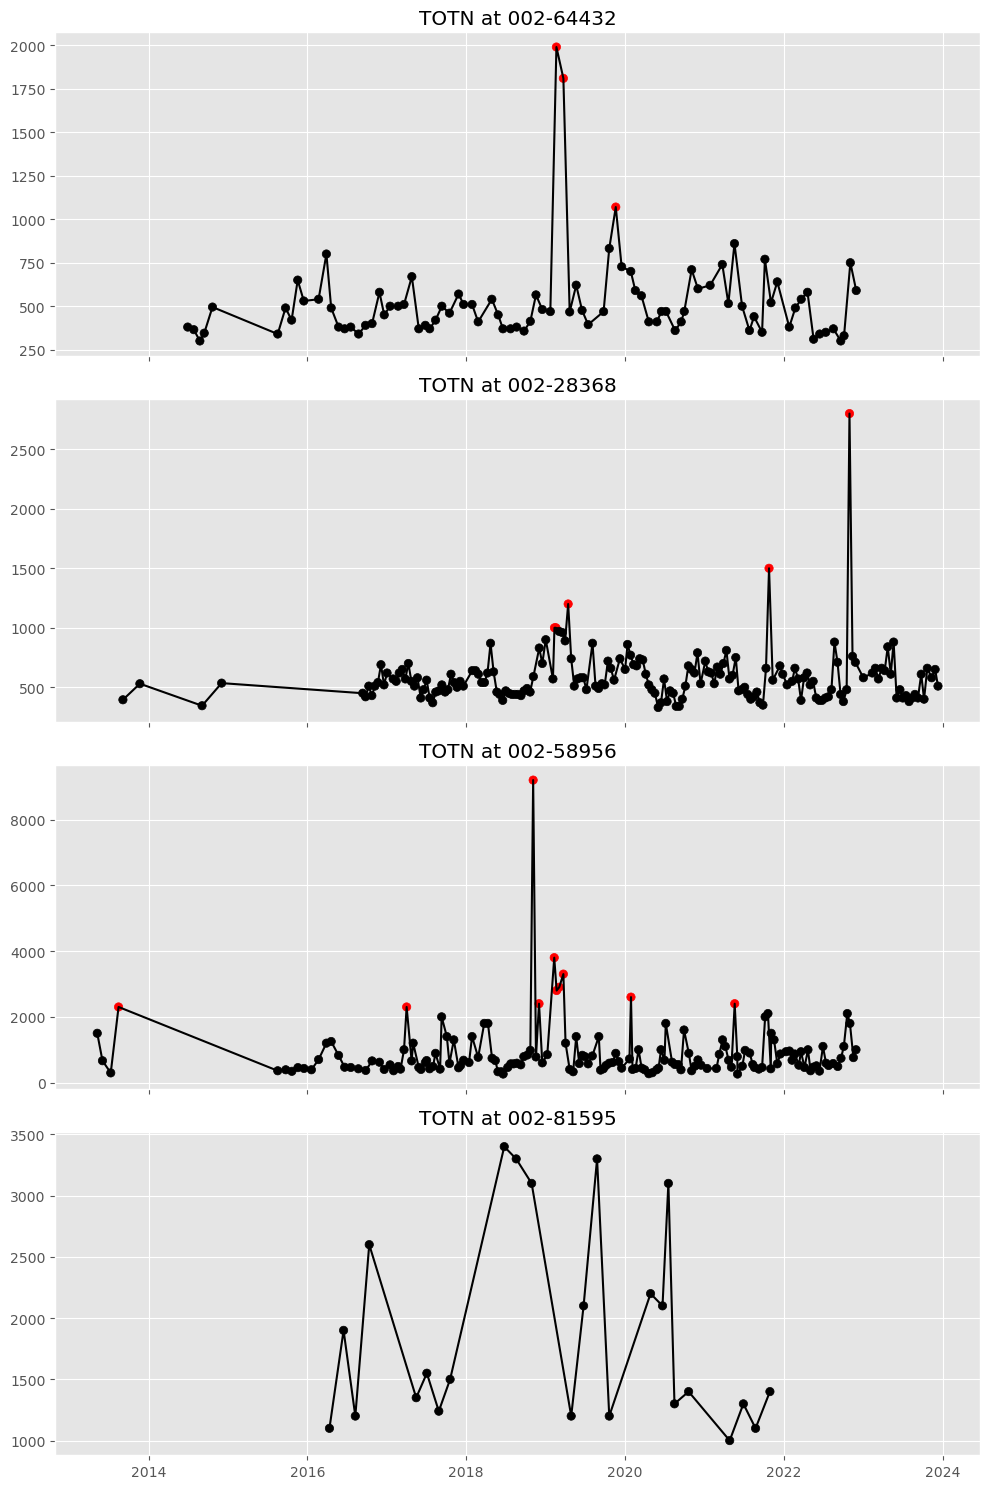

In [8]:
# Plot outliers
fig, axes = plt.subplots(nrows=len(stn_list), ncols=1, figsize=(10, 15), sharex=True)
for row_idx, stn_id in enumerate(stn_list):
    df = obs_df.query("station_id == @stn_id").copy()
    df.sort_values("date", inplace=True)
    df["outlier_col"] = ["r" if i else "k" for i in df["outlier"]]
    axes[row_idx].plot(df["date"], df["value"], "k-")
    axes[row_idx].scatter(
        df["date"],
        df["value"],
        c=df["outlier_col"].tolist(),
    )
    axes[row_idx].set_title(f"TOTN at {stn_id}")
plt.tight_layout()

The plots above show that we have fairly high-frequency monitoring for three of the four sites for several years. Unfortunately, data form Nitelva (`002-81595`) are limited, which means estimates of annual nutrient load for this site will be uncertain (and likely biased-low, due to missing important "events").

In [9]:
# Remove outliers
obs_df = obs_df.query("outlier == False")
obs_df.rename(columns={"value": "TOTN_ug/l"}, inplace=True)
obs_df = obs_df.drop(columns=["par", "flag", "unit", "outlier"])

## 2. Catchment boundaries for water chemistry sites

Get the upstream area for each chemistry monitoring location.

In [10]:
wc_gdf = nivapy.spatial.derive_watershed_boundaries(
    stn_df,
    id_col="station_id",
    xcol="lon",
    ycol="lat",
    crs="epsg:4326",
    min_size_km2=20,
    dem_res_m=40,
    buffer_km=None,
    temp_fold=None,
    reproject=False,
)

Connection successful.


Looping over vassdragsområder:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 002:   0%|          | 0/4 [00:00<?, ?it/s]

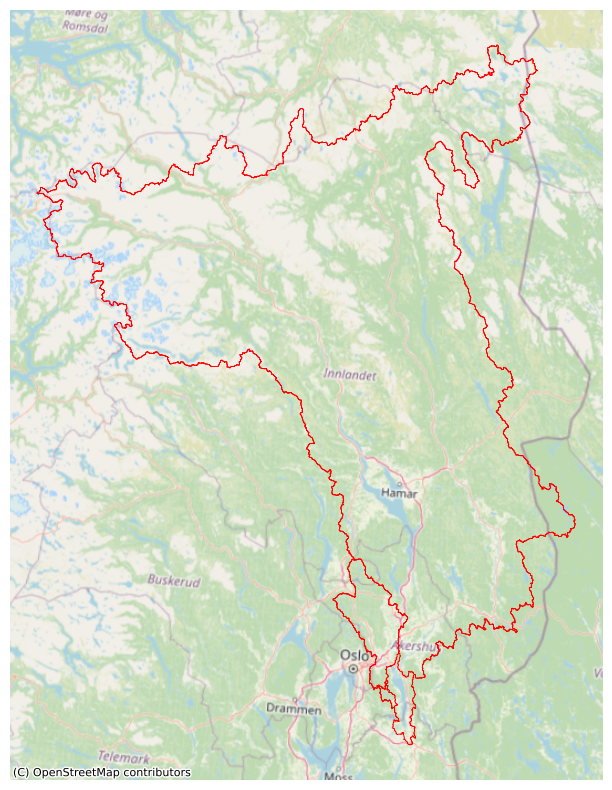

In [11]:
# Plot
ax = wc_gdf.plot(figsize=(10, 10), edgecolor="r", facecolor="none")
cx.add_basemap(ax, crs=wc_gdf.crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

## 3. Get NVE discharge

To estimate fluxes, we need estimates of discharge. Good quality data is available from NVE at Solbergfoss (station ID `2.605.0`), which coincides with chemistry monitoring site `002-28368`. By area-scaling flow values from Solbergfoss, we can also estimate discharge for the other three chemistry stations. This is likely to work well for main inflow at Fetsund, but less well for the two smaller inflows. These calculations can be improved, but basic area scaling should be sufficient for an annual nutrient budget. 

In [12]:
# Get par ID for discharge
par_df = nivapy.da.get_nve_hydapi_parameters()
par_df = par_df.query("parameterName == 'Vannføring'")
par_df

,parameter,parameterName,parameterNameEng,unit
2,1001,Vannføring,Discharge,m³/s


In [13]:
# Get NVE stations
nve_ids = stn_df["nve_dis_stn_id"].unique().tolist()
nve_stn_df = nivapy.da.get_nve_hydapi_stations()
nve_stn_df = nve_stn_df.query("station_id in @nve_ids")
nve_stn_df

,station_id,station_name,latitude,longitude,utmEast_Z33,utmNorth_Z33,masl,riverName,councilNumber,councilName,...,culQ5,culQ10,culQ20,culQ50,culHm,culH5,culH10,culH20,culH50,seriesList
915,2.605.0,Solbergfoss,59.63733,11.15354,283189,6617306,98,Glommavassdraget,3118,Indre Østfold,...,2677.0,3046.0,3217.0,3492.0,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vannføring', 'parameter': ..."


In [14]:
# Get discharge data
par_ids = [1001]
st_dt = f"{vm_st_yr}-01-01"
end_dt = f"{vm_end_yr + 1}-01-01"
q_df = nivapy.da.query_nve_hydapi(nve_ids, par_ids, st_dt, end_dt, resolution=1440)
q_df.head()

,station_id,station_name,parameter,parameter_name,parameter_name_eng,method,datetime,value,unit,correction,quality
0,2.605.0,Solbergfoss,1001,Vannføring,Discharge,Mean,2013-01-01 11:00:00+00:00,526.8333,m³/s,0,3
1,2.605.0,Solbergfoss,1001,Vannføring,Discharge,Mean,2013-01-02 11:00:00+00:00,524.7292,m³/s,0,3
2,2.605.0,Solbergfoss,1001,Vannføring,Discharge,Mean,2013-01-03 11:00:00+00:00,525.0000,m³/s,0,3
3,2.605.0,Solbergfoss,1001,Vannføring,Discharge,Mean,2013-01-04 11:00:00+00:00,524.6250,m³/s,0,3
4,2.605.0,Solbergfoss,1001,Vannføring,Discharge,Mean,2013-01-05 11:00:00+00:00,524.5208,m³/s,0,3


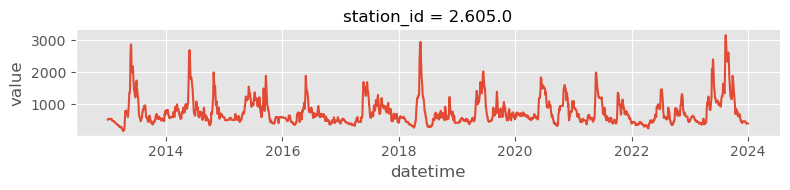

In [15]:
# Plot
sn.relplot(
    data=q_df,
    x="datetime",
    y="value",
    row="station_id",
    kind="line",
    aspect=4,
    height=2,
    facet_kws={"sharey": False, "sharex": True},
)

In [16]:
# Linearly interpolate NoData gaps (i.e. where valid values exist either side of gap),
# but no extrapolation. ALso limit to period where we have complete data for all sites
q_df = (
    q_df.pivot(columns="station_id", index="datetime", values="value")
    .resample("D")
    .mean()
    .interpolate(method="linear", limit_area="inside")
    .dropna(how="any")
)

# Remove time zone info
q_df.index = q_df.index.tz_localize(None)

q_df.head()

station_id,2.605.0
datetime,
2013-01-01,526.8333
2013-01-02,524.7292
2013-01-03,525.0000
2013-01-04,524.6250
2013-01-05,524.5208


## 4. Catchment boundaries for discharge sites

Get the area upstream of the NVE station for area-scaling.

In [17]:
q_gdf = nivapy.spatial.derive_watershed_boundaries(
    nve_stn_df,
    id_col="station_id",
    xcol="longitude",
    ycol="latitude",
    crs="epsg:4326",
    min_size_km2=20,
    dem_res_m=40,
    buffer_km=None,
    temp_fold=None,
    reproject=False,
)

Connection successful.


Looping over vassdragsområder:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 002:   0%|          | 0/1 [00:00<?, ?it/s]

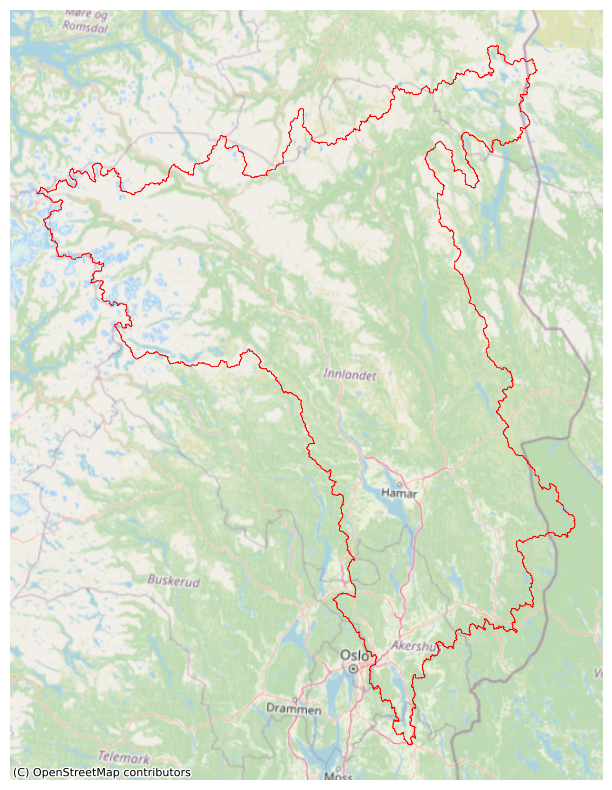

In [18]:
# Plot
ax = q_gdf.plot(figsize=(10, 10), edgecolor="r", facecolor="none")
cx.add_basemap(ax, crs=q_gdf.crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

## 5. Area-scale flows

In [19]:
# Calculate catchment areas and join chem to dis data
wc_gdf["area_km2"] = wc_gdf.to_crs({"proj": "cea"})["geometry"].area / 1e6
q_gdf["area_km2"] = q_gdf.to_crs({"proj": "cea"})["geometry"].area / 1e6
q_gdf.rename({"station_id": "nve_dis_stn_id"}, axis="columns", inplace=True)
wc_gdf = wc_gdf.merge(
    q_gdf[["nve_dis_stn_id", "area_km2"]],
    how="left",
    on="nve_dis_stn_id",
    suffixes=["_chem", "_dis"],
)
wc_gdf

,station_id,geometry,name,lat,lon,nve_dis_stn_id,regine,type,area_km2_chem,area_km2_dis
0,002-28368,"MULTIPOLYGON (((305360 6656400, 305360 6656440...",Glomma ved Solbergfoss,59.637843,11.154619,2.605.0,002.B7,main outflow,40292.179123,40292.203115
1,002-58956,"POLYGON ((279360 6643520, 279360 6643440, 2790...",Børterelva oppstrøms utløp ved Elverk - BRT1 /...,59.757292,11.168781,2.605.0,002.C4B,minor inflow,52.968103,40292.203115
2,002-64432,"MULTIPOLYGON (((305360 6656400, 305360 6656440...",Glomma ved Fetsund - G3,59.923677,11.162343,2.605.0,002.D1,main inflow,38687.801174,40292.203115
3,002-81595,"MULTIPOLYGON (((270920 6698040, 270920 6698000...",Nitelva,59.937102,11.071566,2.605.0,002.CA4,minor inflow,1152.013782,40292.203115


In [20]:
# Scale flows to match chem sites
for idx, row in wc_gdf.iterrows():
    vm_id = row["station_id"]
    nve_id = row["nve_dis_stn_id"]
    area_fac = row["area_km2_chem"] / row["area_km2_dis"]
    q_df[f"q_{vm_id}"] = area_fac * q_df[nve_id]
q_df.head()

station_id,2.605.0,q_002-28368,q_002-58956,q_002-64432,q_002-81595
datetime,,,,,
2013-01-01,526.8333,526.832986,0.692575,505.855237,15.062945
2013-01-02,524.7292,524.728888,0.689809,503.834921,15.002785
2013-01-03,525.0000,524.999687,0.690165,504.094938,15.010528
2013-01-04,524.6250,524.624688,0.689672,503.734870,14.999806
2013-01-05,524.5208,524.520488,0.689535,503.634819,14.996827


## 6. Estimate fluxes

Looking at the plots of the raw monitoring data in Section 1, we have data from all stations from 2016 to 2021. For consistency, I will use this period to estimate annual fluxes. Note that the data record for Nitelva is relatively poor, so flux estimates here will have higher uncertainty.

In [21]:
# Period for flux calculations
fl_st_yr, fl_end_yr = 2016, 2021

In [22]:
df_list = []
for method in [
    # "linear_interpolation",
    # "simple_means",
    # "log_log_linear_regression",
    "ospar_annual",
]:
    for idx, row in wc_gdf.iterrows():
        name = row["name"]
        chem_id = row["station_id"]
        dis_id = row[["nve_dis_stn_id"]]
        site_wc_df = (
            obs_df.query("station_id == @chem_id")
            .copy()
            .set_index("date")[["TOTN_ug/l"]]
            .resample("D")
            .mean()
        )
        site_q_df = q_df[[f"q_{chem_id}"]]
        site_q_df.columns = ["flow_m3/s"]

        flux_df = nivapy.stats.estimate_fluxes(
            site_q_df,
            site_wc_df,
            base_freq="D",
            agg_freq="A",
            method=method,
            st_date=f"{fl_st_yr}-01-01",
            end_date=f"{fl_end_yr}-12-31",
            plot_fold=None,
        )
        flux_df["station_id"] = chem_id
        flux_df["name"] = name
        flux_df["method"] = method

        if method != "ospar_annual":
            del flux_df["flow_m3"]
            flux_df["year"] = flux_df.index.year
            flux_df.reset_index(inplace=True, drop=True)
        else:
            flux_df.reset_index(inplace=True)

        df_list.append(flux_df)

flux_df = pd.concat(df_list, axis="rows")

# Convert kgs to tonnes
for col in ["TOTN_kg"]:
    par = col.split("_")[0]
    flux_df[f"{par}_tonnes"] = flux_df[col] / 1000
    del flux_df[col]

flux_df.drop(columns=["method"], inplace=True)
flux_df = pd.merge(
    flux_df, stn_df[["station_id", "regine", 'type']], how="left", on="station_id"
)
flux_df.head()

/opt/conda/lib/python3.11/site-packages/nivapy3/stats.py:753: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  ann_q_df = (df[["flow_m3/s"]] * 24 * 60 * 60).resample("A").sum()
/opt/conda/lib/python3.11/site-packages/nivapy3/stats.py:753: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  ann_q_df = (df[["flow_m3/s"]] * 24 * 60 * 60).resample("A").sum()
/opt/conda/lib/python3.11/site-packages/nivapy3/stats.py:753: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  ann_q_df = (df[["flow_m3/s"]] * 24 * 60 * 60).resample("A").sum()
/opt/conda/lib/python3.11/site-packages/nivapy3/stats.py:753: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  ann_q_df = (df[["flow_m3/s"]] * 24 * 60 * 60).resample("A").sum()


,year,station_id,name,TOTN_tonnes,regine,type
0,2016,002-28368,Glomma ved Solbergfoss,9482.162093,002.B7,main outflow
1,2017,002-28368,Glomma ved Solbergfoss,11987.808629,002.B7,main outflow
2,2018,002-28368,Glomma ved Solbergfoss,12270.639898,002.B7,main outflow
3,2019,002-28368,Glomma ved Solbergfoss,15469.284513,002.B7,main outflow
4,2020,002-28368,Glomma ved Solbergfoss,14818.818677,002.B7,main outflow


## 7. TEOTIL3 results

This section compares annual fluxes from TEOTIL3 to the fluxes estimated above using observed data. It is worth noting that none of these observations were used during calibration of TEOTIL, so this comparison represents a true "out-of-sample" validation test for the model.

In [23]:
# TEOTIL params
nve_data_year = 2024
st_yr, end_yr = 2013, 2023
agri_loss = "annual"
eval_fold = r"/home/jovyan/shared/common/teotil3/evaluation"

In [24]:
# Read saved data for speed
mod_csv = os.path.join(
    eval_fold,
    f"teo3_results_nve{nve_data_year}_{st_yr}-{end_yr}_agri-{agri_loss}-loss.csv",
)
mod_df = pd.read_csv(mod_csv)
mod_df.head()

,regine,regine_down,accum_agriculture-background_din_kg,accum_agriculture-background_ss_kg,accum_agriculture-background_tdp_kg,accum_agriculture-background_toc_kg,accum_agriculture-background_ton_kg,accum_agriculture-background_totn_kg,accum_agriculture-background_totp_kg,accum_agriculture-background_tpp_kg,...,local_urban_tpp_kg,local_wood_din_kg,local_wood_ss_kg,local_wood_tdp_kg,local_wood_toc_kg,local_wood_ton_kg,local_wood_totn_kg,local_wood_totp_kg,local_wood_tpp_kg,year
0,001.10,001.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,36.1,849.2,0.6,9938.9,186.2,222.3,5.4,4.8,2013
1,001.1A2B,001.1A2A,125.911370,0.752367,3.420677,6341.957245,69.787520,195.698890,3.609359,0.188682,...,5.6,1318.1,29798.4,23.9,384175.8,7138.8,8456.9,210.0,186.1,2013
2,001.1A4D,001.1A4C,15.917595,0.289332,0.117126,464.712744,6.729665,22.647261,0.149627,0.032501,...,0.0,237.2,5272.5,4.3,70016.3,1296.4,1533.6,38.2,33.9,2013
3,001.1M,001.1L,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,473.5,11104.0,8.8,142788.5,2641.6,3115.1,78.3,69.5,2013
4,001.21,001.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,5.0,117.0,0.1,1386.1,25.9,30.9,0.8,0.7,2013


In [25]:
def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix) :]
    return text


# Tidy modelled data for comparison
cols = [col for col in mod_df.columns if col.startswith("accum_")]
mod_df = mod_df[["regine", "year"] + cols].copy()
cols = [remove_prefix(col, "accum_") for col in cols]
mod_df.columns = ["regine", "year"] + cols
for col in cols:
    if col.endswith("_kg"):
        mod_df[col[:-3] + "_tonnes"] = mod_df[col] / 1000
    del mod_df[col]

# Merge
comp_df = pd.merge(flux_df, mod_df, how="left", on=["regine", "year"])
comp_df.head()

,year,station_id,name,TOTN_tonnes,regine,type,agriculture-background_din_tonnes,agriculture-background_ss_tonnes,agriculture-background_tdp_tonnes,agriculture-background_toc_tonnes,...,urban_totp_tonnes,urban_tpp_tonnes,wood_din_tonnes,wood_ss_tonnes,wood_tdp_tonnes,wood_toc_tonnes,wood_ton_tonnes,wood_totn_tonnes,wood_totp_tonnes,wood_tpp_tonnes
0,2016,002-28368,Glomma ved Solbergfoss,9482.162093,002.B7,main outflow,472.710259,629.012611,2.919358,6591.597293,...,13.996447,2.223912,333.982561,1370.490669,10.380324,48355.735086,1782.846181,2116.828742,24.935296,14.554972
1,2017,002-28368,Glomma ved Solbergfoss,11987.808629,002.B7,main outflow,468.233519,760.283934,3.355617,7570.127375,...,16.073230,2.553610,383.668527,1370.490669,11.926401,55549.721507,2048.135431,2431.803958,28.646465,16.720064
2,2018,002-28368,Glomma ved Solbergfoss,12270.639898,002.B7,main outflow,736.366793,906.893398,3.821070,8612.109173,...,18.286670,2.904939,436.510235,1370.490669,13.567807,63199.748330,2330.222386,2766.732621,32.590558,19.022751
3,2019,002-28368,Glomma ved Solbergfoss,15469.284513,002.B7,main outflow,587.963477,902.734159,3.807900,8585.100657,...,18.232428,2.896307,435.083035,1370.490669,13.523087,62993.595661,2322.584274,2757.667309,32.484180,18.961093
4,2020,002-28368,Glomma ved Solbergfoss,14818.818677,002.B7,main outflow,587.103806,1082.431492,4.353792,9803.645433,...,20.816271,3.306959,496.802957,1370.490669,15.441670,71929.968280,2652.024153,3148.827110,37.091453,21.649783


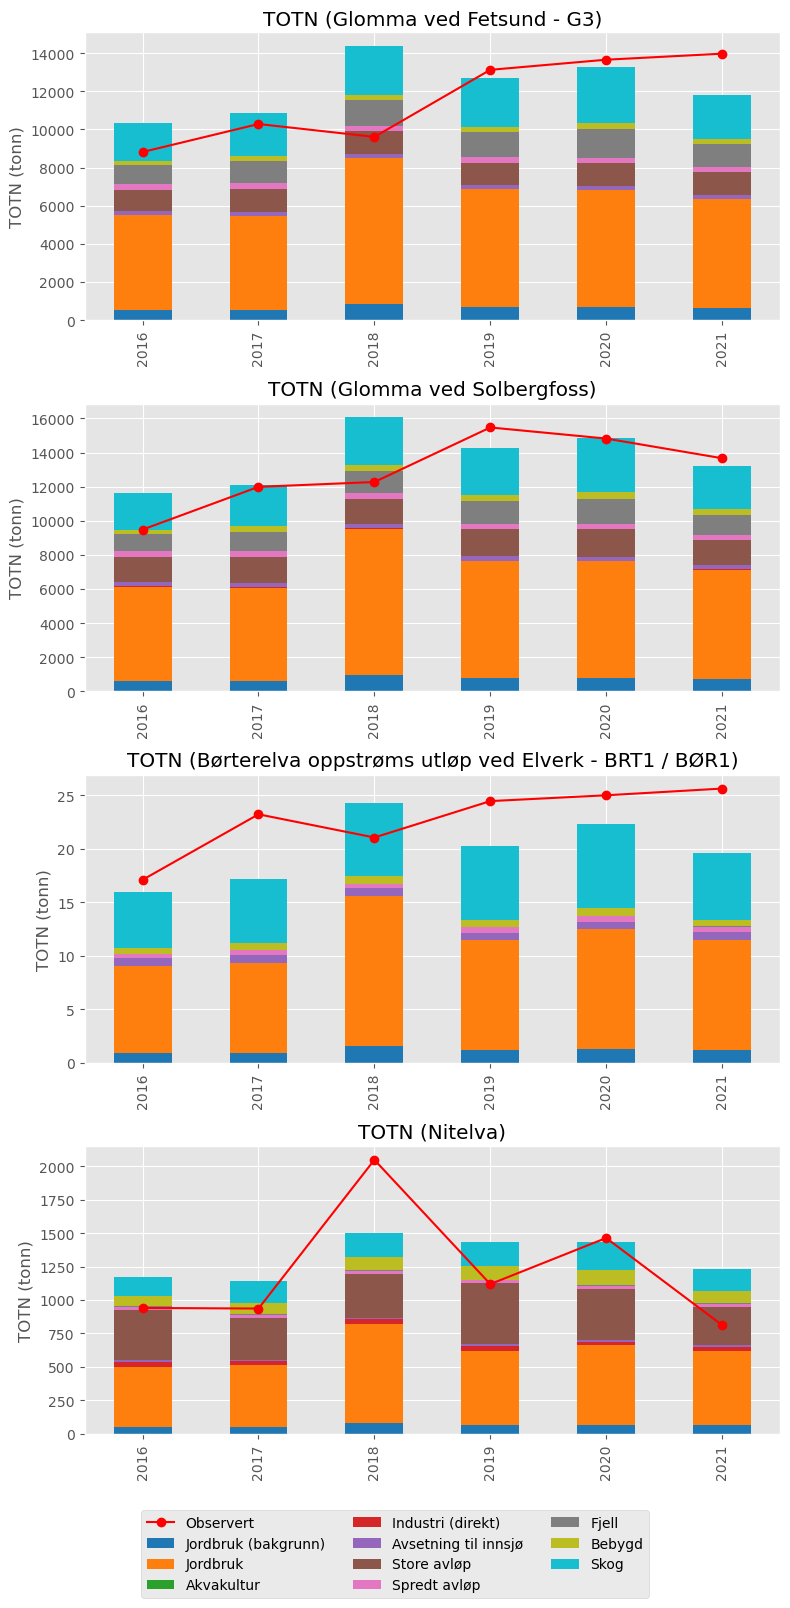

In [26]:
# Plot results
pars = ["TOTN"]
site_list = stn_df["station_id"].tolist()
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 15))
for row_idx, row in stn_df.iterrows():
    stn_id = row["station_id"]
    name = row["name"]
    stn_comp_df = comp_df.query("station_id == @stn_id")
    for col_idx, par in enumerate(pars):
        names_dict = {
            f"agriculture-background_{par.lower()}_tonnes": "Jordbruk (bakgrunn)",
            f"agriculture_{par.lower()}_tonnes": "Jordbruk",
            f"aquaculture_{par.lower()}_tonnes": "Akvakultur",
            f"industry_{par.lower()}_tonnes": "Industri (direkt)",
            f"lake_{par.lower()}_tonnes": "Avsetning til innsjø",
            f"large-wastewater_{par.lower()}_tonnes": "Store avløp",
            f"spredt_{par.lower()}_tonnes": "Spredt avløp",
            f"upland_{par.lower()}_tonnes": "Fjell",
            f"urban_{par.lower()}_tonnes": "Bebygd",
            f"wood_{par.lower()}_tonnes": "Skog",
        }
        par_cols = [
            col
            for col in stn_comp_df.columns
            if par.lower() in (i.lower() for i in col.split("_"))
        ]

        stn_comp_par_df = stn_comp_df.set_index("year")[par_cols]
        stn_comp_par_df.rename(columns=names_dict, inplace=True)
        stn_comp_par_df.drop(columns=[f"{par}_tonnes"]).plot(
            kind="bar",
            stacked=True,
            ax=axes[row_idx],
            legend=False,
            cmap="tab10",
        )
        axes[row_idx].plot(
            stn_comp_par_df.index - stn_comp_par_df.index.min(),
            stn_comp_par_df[f"{par}_tonnes"],
            marker="o",
            color="red",
            label="Observert",
        )
        axes[row_idx].set_title(f"{par} ({name})")
        axes[row_idx].set_ylabel(f"{par} (tonn)")
        axes[row_idx].set_xlabel("")
plt.tight_layout()

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center", bbox_to_anchor=(0.5, -0.04), ncol=3)
plt.savefig("oyeren_mod_vs_obs_fluxes.png", dpi=200, bbox_inches="tight")

Based on the plots above, I think TEOTIL3 does a pretty good job of simulating annual nutrient fluxes for catchments around Øyeren.

## 8. Nutrient budget

We can now use the monitoring data to estimate an overall nutrient budget for Øyeren for the period from 2016 to 2021. According to NVE, the residence time of water in Øyeren is short (0.06 years; ~22 days). A data period of 6 years should therefore be sufficient to give a reasonable picture of nutrient retention.

First, we can group the monitoring data according to the type of inflow/outflow.

In [27]:
print("Sum of monitored inflows and outflows from 2016 to 2021:")
bud_df = flux_df.groupby(["type"]).sum(numeric_only=True)["TOTN_tonnes"].reset_index()
display(bud_df)

print("\nCatchment areas covered by monitoring (in km2):")
area_df = wc_gdf.groupby("type").sum(numeric_only=True)["area_km2_chem"]
display(area_df)

print("\nScaling factor for 'minor inflows' to account for unmonitored minor catchments:")
minor_area_fac = (area_df["main outflow"] - area_df["main inflow"]) / area_df[
    "minor inflow"
]
print(f"  {minor_area_fac:.2f}")


print("\nFluxes adjusted for unmonitored areas (2016 to 2021):")
bud_df["TOTN_tonnes"] = np.where(
    bud_df["type"] == "minor inflow", bud_df["TOTN_tonnes"] * minor_area_fac, bud_df["TOTN_tonnes"]
)
display(bud_df)

Sum of monitored inflows and outflows from 2016 to 2021:


,type,TOTN_tonnes
0,main inflow,69446.238284
1,main outflow,77693.805052
2,minor inflow,7453.901418



Catchment areas covered by monitoring (in km2):


type
main inflow     38687.801174
main outflow    40292.179123
minor inflow     1204.981885
Name: area_km2_chem, dtype: float64


Scaling factor for 'minor inflows' to account for unmonitored minor catchments:
  1.33

Fluxes adjusted for unmonitored areas (2016 to 2021):


,type,TOTN_tonnes
0,main inflow,69446.238284
1,main outflow,77693.805052
2,minor inflow,9924.526845


The first dataframe in the output above shows that, between 2016 and 2021, about 69 kilotonnes of TOTN entered the lake at Fetsund, and about 78 kilotonnes were transported past Solbergfoss (just downstream of the outflow). Minor inflows from Nitelva, Leira and Børterelva contributed another 7 kilotonnes. 

In addition, Øyeren receives inputs from other smaller catchments without monitoring data. The upstream area calculations in Section 5 show that the total area upstream of Solbergfoss is 40 292 km2, while the area above Fetsund is 38 688 km2. This means that minor catchments around Øyeren have a combined area of 40292 - 38688 = 1604 km2. Of this, Nitelva and Leira have an upsteam area of 1152 km2, and Børterelva has an upstream area of 53 km2. This means 1205 km2 out 1604 km2 are covered by monitoring. For the remaining unmonitored area (399 km2), I have assumed that mean nutrient losses per km2 are the same as the average from Nitelva, Leira and Børterelva i.e. I will scale the `minor inflow` fluxes in the first dataframe above by a factor of 1604/1205 = 1.33. This is shown in the second datafarme, which should give a reasonable estimate of the total amount of N added to Øyeren between 2016 and 2021.

In [28]:
# Estimate retention
ret_df = bud_df.set_index('type')['TOTN_tonnes']
total_in = (
    ret_df["main inflow"]
    + ret_df["minor inflow"]
)
total_out = ret_df["main outflow"]
retention = 1 - (total_out / total_in)
print(f"Retention for the period from {fl_st_yr} to {fl_end_yr}:")
print(f"  {par}: {retention:.2f}.")

Retention for the period from 2016 to 2021:
  TOTN: 0.02.


The transmission factor for TOTN is simply the outflow flux divided by the total inflow flux, and retention is 1 minus this factor. **Based on monitoring data from 2016 to 2021, the estimated retention of TOTN in Øyeren is 2%** This agrees very closely with the estimate from TEOTIL3 (also 2%), and it is also in line with the previous estimate from [Holtan (1991)](https://niva.brage.unit.no/niva-xmlui/handle/11250/206295), who estimated 4% based on monitoring data from a much earlier period.

These calculations could be improved in several ways (e.g. by including atmospheric deposition directly to the lake surface). However, for a quick back-of-the-envelope calculation, I believe all major sources and sinks of N have been accounted for and the result is fairly robust. 